In [157]:
#This script performs several setps of time series analyis
# First section: Order selection for ARIMAX model based on lowest AIC and BIC
# Second section: Testing for model performance improvement

# The aim of our research is not to identify multicollinearity, endogeneity, the only purpose is to test in all the following scripts whether the predictive power of two different models can be improved.

import pandas as pd
import numpy as np
import random
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


import warnings
warnings.filterwarnings('ignore')
random.seed(42)

df = pd.read_csv("./tsdata/modeldata.csv", index_col='Date', parse_dates=True)
df.index.freq = "MS"


scaler = MinMaxScaler()
df[["returns", "msci"]] = scaler.fit_transform(df[["returns", "msci"]])

train = df[:'2020-01-01']
test = df['2020-01-02':]

In [158]:
#Model fitting
y = train['returns']
X_msci = train[["msci"]]
X_sent = train[["sentiment"]] #"sentiment" is our own sentiment score derived fromt the sentiment LDA
X_both = train[["msci","sentiment"]]#Both the MSCI and the sentiment score are included

def evaluateModel(data, exog, order):
    model = SARIMAX(data, exog=exog, order=(order[0], 0, order[1]), enforce_stationarity=True, enforce_invertibility=True)
    model_fit = model.fit(disp=False, maxiter = 300)
    return order, model_fit.aic, model_fit.bic

orders = [(p, q) for p in range(5) for q in range(5) if (p, q) != (0, 0)]

results_base = []
results_msci = []
results_sent = []
results_both = []

#Base model
for order in orders:
    try:
        order, aic, bic = evaluateModel(y, None, order)
        results_base.append([order, aic, bic])
    except Exception as e:
        print(f"Order {order} for base model failed: {e}")


#Including MSCI
for order in orders:
    try:
        order, aic_msci, bic_msci = evaluateModel(y, X_msci, order)
        results_msci.append([order, aic_msci, bic_msci])
    except Exception as e:
        print(f"Order {order} with msci failed: {e}")

#Including own sentiment score
for order in orders:
    try:
        order, aic_sent, bic_sent = evaluateModel(y, X_sent, order)
        results_sent.append([order, aic_sent, bic_sent])
    except Exception as e:
        print(f"Order {order} with sentiment failed: {e}")


#Including both scores
for order in orders:
    try:
        order, aic_both, bic_both = evaluateModel(y, X_both, order)
        results_both.append([order, aic_both, bic_both])
    except Exception as e:
        print(f"Order {order} with both variables failed: {e}")


df_base = pd.DataFrame(results_base, columns=['Order', 'AIC', 'BIC'])
df_msci = pd.DataFrame(results_msci, columns=['Order', 'AIC', 'BIC'])
df_sent = pd.DataFrame(results_sent, columns=['Order', 'AIC', 'BIC'])
df_both = pd.DataFrame(results_both, columns=['Order', 'AIC', 'BIC'])

In [159]:
min_aic_base_index = df_base['AIC'].idxmin()
min_bic_base_index = df_base['BIC'].idxmin()

min_aic_base_order = df_base.loc[min_aic_base_index]
min_bic_base_order = df_base.loc[min_bic_base_index]


min_aic_msci_index = df_msci['AIC'].idxmin()
min_bic_msci_index = df_msci['BIC'].idxmin()

min_aic_msci_order = df_msci.loc[min_aic_msci_index]
min_bic_msci_order = df_msci.loc[min_bic_msci_index]


min_aic_sent_index = df_sent['AIC'].idxmin()
min_bic_sent_index = df_sent['BIC'].idxmin()

min_aic_sent_order = df_sent.loc[min_aic_sent_index]
min_bic_sent_order = df_sent.loc[min_bic_sent_index]


min_aic_both_index = df_both['AIC'].idxmin()
min_bic_both_index = df_both['BIC'].idxmin()

min_aic_both_order = df_both.loc[min_aic_both_index]
min_bic_both_order = df_both.loc[min_bic_both_index]


# Printing the results
print("Base model with lowest AIC:", min_aic_base_order)
print("Base model with lowest BIC:", min_bic_base_order)



print("MSCI model with lowest AIC:", min_bic_msci_order)
print("MSCI model with lowest BIC:", min_bic_msci_order)


print("Sent model with lowest AIC:", min_bic_sent_order)
print("Sent model with lowest BIC:", min_bic_sent_order)


print("Both model with lowest AIC:", min_bic_both_order)
print("Both model with lowest BIC:", min_bic_both_order)

Base model with lowest AIC: Order       (1, 1)
AIC     -62.658709
BIC     -54.934576
Name: 5, dtype: object
Base model with lowest BIC: Order       (1, 1)
AIC     -62.658709
BIC     -54.934576
Name: 5, dtype: object
MSCI model with lowest AIC: Order       (0, 1)
AIC     -51.417523
BIC      -43.69339
Name: 0, dtype: object
MSCI model with lowest BIC: Order       (0, 1)
AIC     -51.417523
BIC      -43.69339
Name: 0, dtype: object
Sent model with lowest AIC: Order       (1, 1)
AIC     -60.806418
BIC     -50.507574
Name: 5, dtype: object
Sent model with lowest BIC: Order       (1, 1)
AIC     -60.806418
BIC     -50.507574
Name: 5, dtype: object
Both model with lowest AIC: Order       (0, 1)
AIC     -49.554933
BIC     -39.256089
Name: 0, dtype: object
Both model with lowest BIC: Order       (0, 1)
AIC     -49.554933
BIC     -39.256089
Name: 0, dtype: object


In [160]:
basemodel = SARIMAX(y, None, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
basefit = basemodel.fit(disp=False, maxiter = 300)
basefit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   97
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  34.329
Date:                Sat, 20 Apr 2024   AIC                            -62.659
Time:                        11:51:47   BIC                            -54.935
Sample:                    01-01-2012   HQIC                           -59.535
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   7.35e-06   1.36e+05      0.000       1.000       1.000
ma.L1         -0.9991      0.059    -16.840      0.000      -1.115      -0.883
sigma2         0.0270      0.005      5.847      0.000       0.018       0.036
===================================================================================
Ljung-Box (L1) (Q):                   1.56   Jarque-Bera (JB):                 3.80
Prob(Q):                              0.21   Prob(JB):                         0.15
Heteroskedasticity (H):               1.12   Skew:                            -0.47
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [161]:
acorr_ljungbox(basefit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,10.281045,0.416192


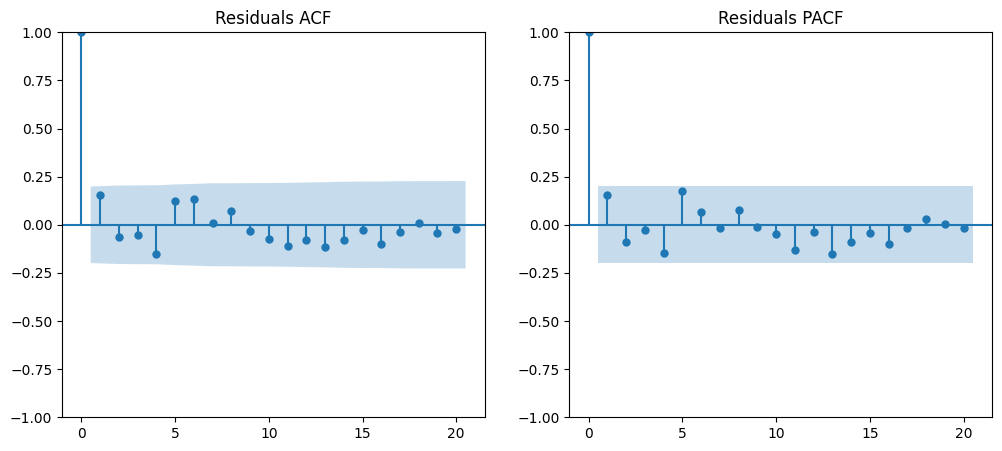

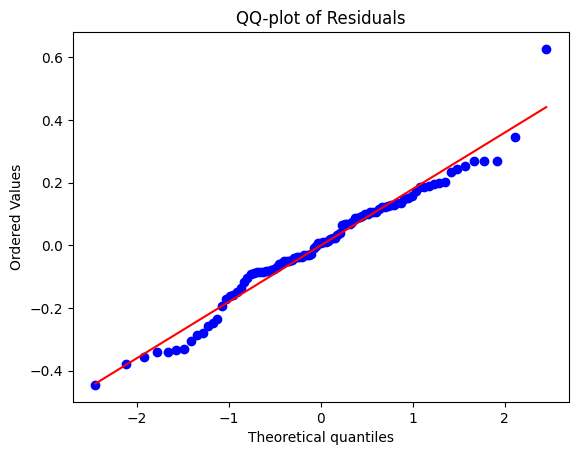

In [162]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(basefit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(basefit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(basefit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [163]:
mscimodel = SARIMAX(y, X_msci, order=(0, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
mscifit = mscimodel.fit(disp=False, maxiter = 300)
mscifit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   97
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  28.709
Date:                Sat, 20 Apr 2024   AIC                            -51.418
Time:                        11:51:48   BIC                            -43.693
Sample:                    01-01-2012   HQIC                           -48.294
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
msci           0.6229      0.030     21.028      0.000       0.565       0.681
ma.L1          0.1039      0.102      1.015      0.310      -0.097       0.305
sigma2         0.0324      0.005      6.609      0.000       0.023       0.042
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.86
Prob(Q):                              0.83   Prob(JB):                         0.65
Heteroskedasticity (H):               1.09   Skew:                            -0.23
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [164]:
acorr_ljungbox(mscifit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,9.250717,0.508487


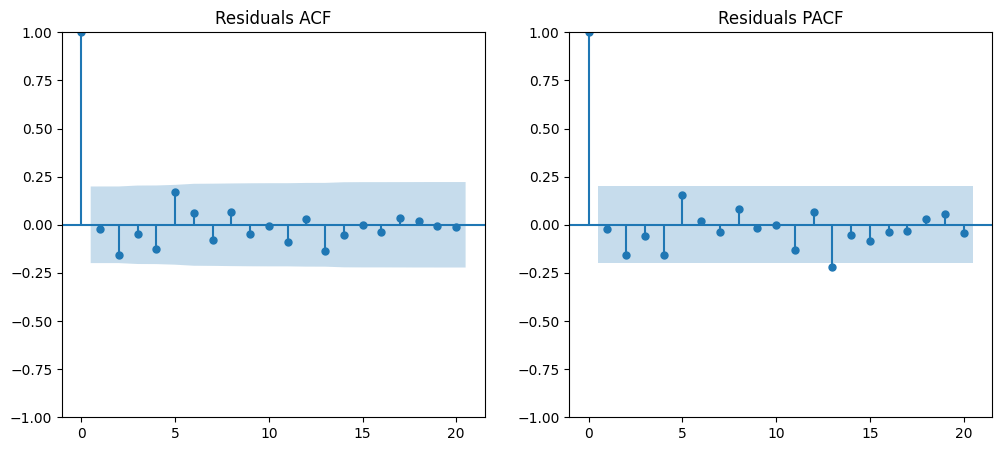

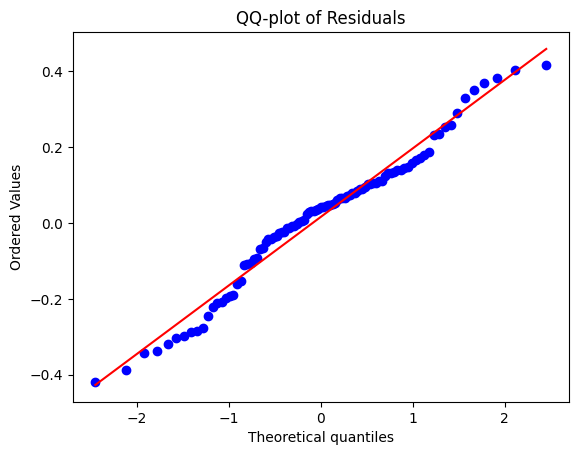

In [165]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(mscifit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(mscifit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(mscifit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [166]:
sentmodel = SARIMAX(y, X_sent, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
sentfit = sentmodel.fit(disp=False, maxiter = 300)
sentfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   97
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  34.403
Date:                Sat, 20 Apr 2024   AIC                            -60.806
Time:                        11:51:48   BIC                            -50.508
Sample:                    01-01-2012   HQIC                           -56.642
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sentiment      0.0152      0.036      0.416      0.678      -0.056       0.087
ar.L1          1.0000   8.26e-06   1.21e+05      0.000       1.000       1.000
ma.L1         -0.9991      0.065    -15.386      0.000      -1.126      -0.872
sigma2         0.0269      0.005      5.741      0.000       0.018       0.036
===================================================================================
Ljung-Box (L1) (Q):                   1.33   Jarque-Bera (JB):                 3.84
Prob(Q):                              0.25   Prob(JB):                         0.15
Heteroskedasticity (H):               1.10   Skew:                            -0.48
Prob(H) (two-sided):                  0.80   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [167]:
acorr_ljungbox(sentfit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,10.005157,0.440041


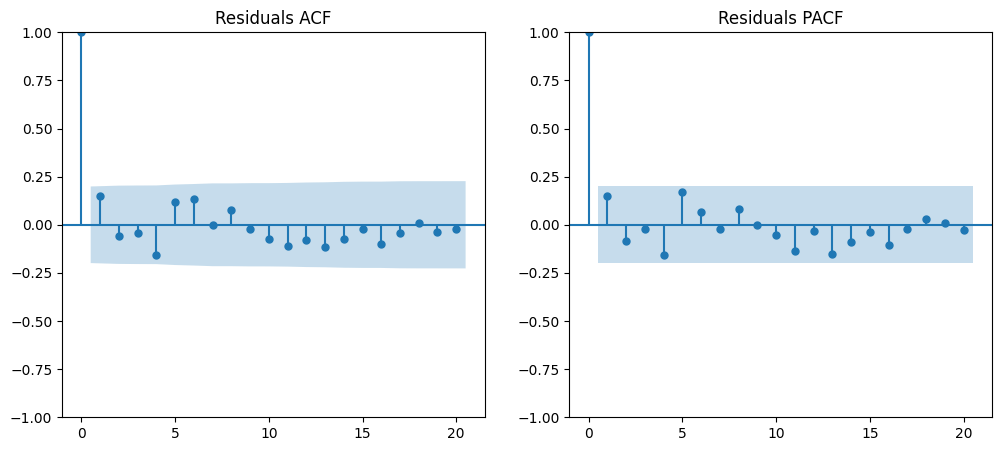

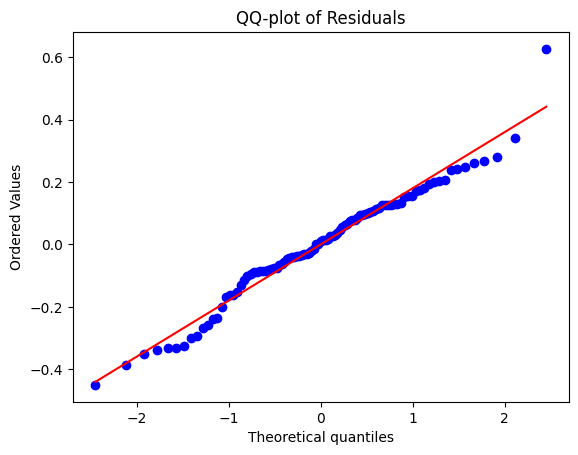

In [168]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(sentfit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(sentfit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(sentfit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [169]:
bothmodel = SARIMAX(y, X_both, order=(0, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
bothfit = bothmodel.fit(disp=False, maxiter = 300)
bothfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   97
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  28.777
Date:                Sat, 20 Apr 2024   AIC                            -49.555
Time:                        11:51:49   BIC                            -39.256
Sample:                    01-01-2012   HQIC                           -45.391
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
msci           0.6211      0.030     20.561      0.000       0.562       0.680
sentiment     -0.0173      0.045     -0.382      0.702      -0.106       0.071
ma.L1          0.1208      0.110      1.096      0.273      -0.095       0.337
sigma2         0.0323      0.005      6.622      0.000       0.023       0.042
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.86
Prob(Q):                              0.81   Prob(JB):                         0.65
Heteroskedasticity (H):               1.11   Skew:                            -0.23
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [170]:
acorr_ljungbox(bothfit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,9.306692,0.503266


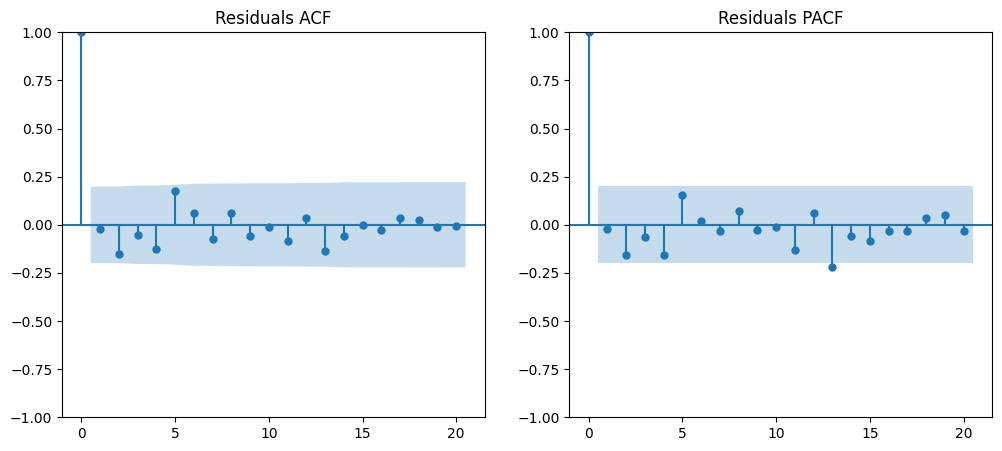

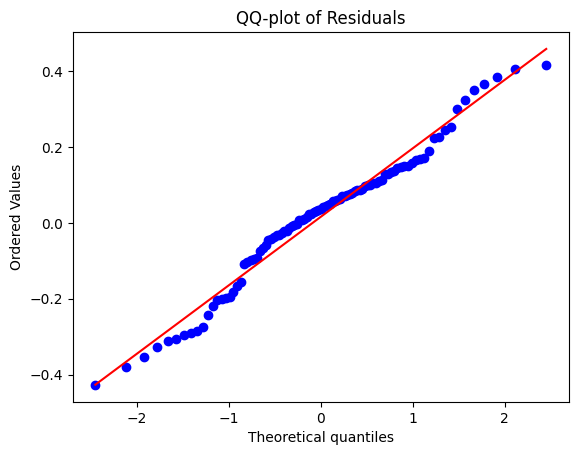

In [171]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(bothfit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(bothfit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(bothfit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [172]:
ytest = test["returns"]

Xmsci_test = test[["msci"]]
Xsent_test = test[["sentiment"]]
Xboth_test = test[["msci", "sentiment"]]


pbase = basefit.get_forecast(steps=len(ytest), exog=None).predicted_mean
pmsci = mscifit.get_forecast(steps=len(ytest), exog=Xmsci_test).predicted_mean
psent = sentfit.get_forecast(steps=len(ytest), exog=Xsent_test).predicted_mean
pboth = bothfit.get_forecast(steps=len(ytest), exog=Xboth_test).predicted_mean

def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))


errors = {
    'Model': ['Base', 'MSCI', 'Sentiment', 'Both'],
    'MAPE': [mape(ytest, pbase), mape(ytest, pmsci), mape(ytest, psent), mape(ytest, pboth)],
    'RMSE': [rmse(ytest, pbase), rmse(ytest, pmsci), rmse(ytest, psent), rmse(ytest, pboth)]
}

results_df = pd.DataFrame(errors)
print(results_df)

       Model        MAPE      RMSE
0       Base  511.564230  0.268669
1       MSCI  414.088543  0.318021
2  Sentiment  502.097503  0.268972
3       Both  424.585493  0.317517


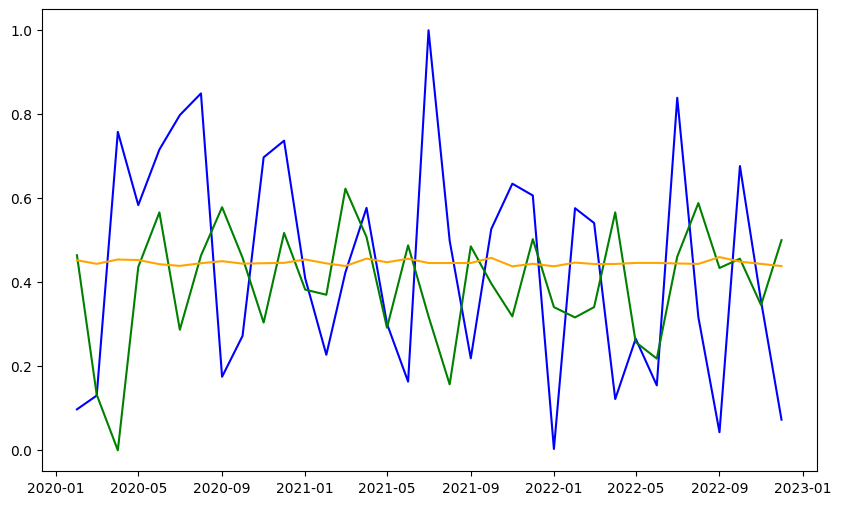

In [173]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, ytest, label='Actual', color='blue')
#plt.plot(test.index, pbase, label='Base Model', color='red')
plt.plot(test.index, pmsci, label='MSCI Model', color='green')
plt.plot(test.index, psent, label='Sentiment Score Model', color='orange')
#plt.plot(test.index, pboth, label='Both Exo Model', color='black')
